In [71]:
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import numpy as np

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

Read the csv file into a dataframe

In [139]:
cwd = os.getcwd()
parent = os.path.dirname(cwd)
csv_path = os.path.join(parent, "data/", "master_results.csv")

In [140]:
df = pd.read_csv(csv_path, low_memory=False)
df.head(3)

,p_in,Re,Geometry
0,11.922400,532.38,channelStripRe
1,12.093420,760.11,channelStripRe
2,6.648019,1898.78,leftStripBendRe


In [141]:
df['p_in'] = np.log1p(df['p_in'])

In [142]:
procs = [Categorify,  Normalize]
cat = "Geometry"
cont = "Re"
dep_var = "p_in"

We will randomly split the dataset into a training and validation sets.

In [165]:
splits = RandomSplitter()(df)
tabular_set = TabularPandas(
    df=df,
    procs=procs,
    cat_names=cat,
    cont_names=cont,
    y_names=dep_var,
    y_block=RegressionBlock(),
    splits=splits
)

In [166]:
# Create DataLoaders
dls = tabular_set.dataloaders(bs=16)  # Batch size 64

In [167]:
learn = tabular_learner(
    dls, 
    layers=[200, 100],  
    metrics=mae)

Let's check the embeddings

In [168]:
learn.model.embeds

ModuleList(
  (0): Embedding(9, 5)
)

Find the optimal learning rate

In [169]:
# Train for a few epochs
learn.fit(5, lr=0.08)  # Very small LR to test

epoch,train_loss,valid_loss,mae,time
0,5.279543,23.986778,1.157609,00:00
1,4.696648,22.597826,0.707626,00:00
2,6.149751,22.250059,0.832343,00:00
3,7.190246,21.957239,0.825449,00:00
4,5.058524,21.823225,0.729162,00:00


In [170]:
preds, targets = learn.get_preds(dl=dls.valid)


In [171]:
preds = preds.numpy().flatten()
targets = targets.numpy().flatten()

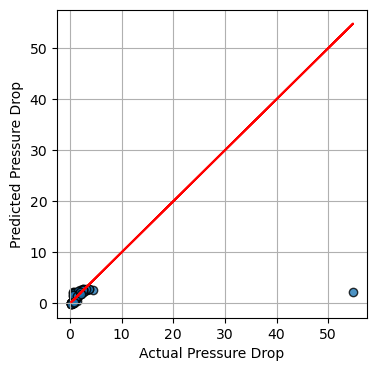

In [172]:
plt.figure(figsize=(4,4))
plt.scatter(targets, preds, alpha=0.8, edgecolors='black')
plt.plot(targets, targets, color='red')
plt.xlabel("Actual Pressure Drop")
plt.ylabel("Predicted Pressure Drop")
plt.grid()
plt.show()